<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Aprendizaje%20no%20Supervisado/LoanDefaultProbability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Probabilidad de impago de préstamos.**
El objetivo de este proyecto es construir un modelo de aprendizaje automático para predecir la probabilidad de que un préstamo entre en impago.

## **Content.**

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Data Preparation and Feature Selection](#2)
    * [3.1. Preparing the predicted variable](#2.1)    
    * [3.2. Feature Selection-Limit the Feature Space](#2.2)
        * [3.2.1.  Features elimination by significant missing values ](#2.2.1)
        * [3.2.2.  Features elimination based on the intutiveness](#2.2.2)
        * [3.2.3.  Features elimination based on the correlation](#2.2.3)   
* [4. Feature Engineering and Exploratory Analysis](#3)
    * [4.1 Feature Analysis and Exploration](#3.1)
        * [4.1.1. Analysing the categorical features](#3.1.1)
        * [4.1.2  Analysing the continuous features ](#3.1.2) 
    * [4.2.Encoding Categorical Data](#3.2)
    * [4.3.Sampling Data](#3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)

<a id='0'></a>
# 1. Problem Definition

El problema se define en el marco de la clasificación, donde la variable prevista es "Charge-Off ". Un "charge-off" es una deuda que un acreedor ha dejado de intentar cobrar después de que haya dejado de pagar durante varios meses. La variable de predicción toma el valor de 1 en caso de que se produzca una suspensión de pagos y de 0 en caso contrario.

Este caso de estudio tiene como objetivo analizar los datos de los préstamos hasta el 2007-2017Q3 de Lending Club disponibles en Kaggle. El conjunto de datos contiene más de 887 mil observaciones y 150 variables entre las cuales una describe el estado del préstamo.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

# Libraries for Saving the Model
from pickle import dump
from pickle import load

<a id='1.2'></a>
## 2.2. Loading the Data

In [2]:
# load dataset
loans = pd.read_csv('/content/accepted_2007_to_2017.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dataset = loans

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable

In [6]:
# Vamos a intentar predecir la variable loan_status. ¿Cuáles son los valores de esta variable?
dataset['loan_status'].value_counts(dropna=False)

Fully Paid                                             564833
Current                                                554985
Charged Off                                            140952
Late (31-120 days)                                      15809
In Grace Period                                          7279
Late (16-30 days)                                        3841
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    44
NaN                                                        15
Name: loan_status, dtype: int64

* Vamos a tratar de conocer las diferencias en las características entre los préstamos terminados que han sido totalmente pagados o cancelados. No vamos a considerar los préstamos que están al día, que no cumplen la política de crédito, que están en mora o que tienen un estado perdido. Así que sólo mantendremos los préstamos con estado "Totalmente pagado" o "Cargado".

In [7]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]

dataset['loan_status'].value_counts(dropna=False)

dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.80029
Charged Off    0.19971
Name: loan_status, dtype: float64

Aproximadamente el 80% de los préstamos restantes han sido pagados en su totalidad y el 20% han sido cargados, por lo que tenemos un problema de clasificación algo desequilibrado.

In [8]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)

<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

El conjunto de datos completo tiene 150 características para cada préstamo. Eliminaremos las características en los siguientes pasos utilizando tres enfoques diferentes:

* Eliminar las características que tengan más de un 30% de valores perdidos.
* Eliminar las características que no son intuitivas en base a un juicio subjetivo.
* Eliminar las características con baja correlación con la variable predicha


<a id='2.2.1'></a>
### 3.2.1.  Features elimination by significant missing values

Primero se calcula el porcentaje de datos que faltan para cada característica:

In [9]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

next_pymnt_d                                  1.000000
member_id                                     1.000000
orig_projected_additional_accrued_interest    0.999908
sec_app_mths_since_last_major_derog           0.999609
hardship_dpd                                  0.999493
hardship_reason                               0.999493
hardship_status                               0.999493
deferral_term                                 0.999493
hardship_amount                               0.999493
hardship_start_date                           0.999493
dtype: float64

In [10]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [11]:
len(drop_list)

58

In [12]:
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(705785, 92)

<a id='2.2.2'></a>
### 3.2.2.  Features elimination based on the intutiveness

In [13]:
print(sorted(dataset.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

* La lista que se mantiene es la siguiente:

In [14]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

len(keep_list)

40

In [15]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape

(705785, 39)

<a id='2.2.3'></a>
### 3.2.3.  Features elimination based on the correlation

In [16]:
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['charged_off'])

In [17]:
correlation_chargeOff.sort_values(ascending=False)

charged_off              1.000000
last_pymnt_amnt          0.362838
int_rate                 0.242947
fico_range_low           0.136101
fico_range_high          0.136100
dti                      0.119843
acc_open_past_24mths     0.100160
bc_open_to_buy           0.084554
avg_cur_bal              0.082523
num_actv_rev_tl          0.076178
bc_util                  0.075737
mort_acc                 0.071338
revol_util               0.070626
funded_amnt              0.064195
loan_amnt                0.064085
mo_sin_rcnt_rev_tl_op    0.054438
annual_inc               0.049020
mo_sin_old_rev_tl_op     0.048080
installment              0.041216
open_acc                 0.034518
pub_rec                  0.022085
pub_rec_bankruptcies     0.016642
revol_bal                0.014161
total_acc                0.008726
Name: charged_off, dtype: float64

In [18]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
print(drop_list_corr)

['pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']


In [19]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

(705785, 35)

<a id='3'></a>
# 4. Feature Engineering and Exploratory Analysis

In [20]:
dataset.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
count,705785.000000,705785.000000,705785.000000,705785.000000,7.057850e+05,705763.000000,705785.000000,705785.00000,705785.000000,705369.000000,705785.000000,658504.000000,638246.000000,651890.000000,651467.000000,638257.000000,638257.000000,658504.000000,638258.000000,705785.000000
mean,14237.435621,14221.395042,13.487580,433.981695,7.459489e+04,17.691321,695.529014,699.52912,11.445784,53.768112,5571.390172,4.611219,13443.023290,9176.616492,62.520896,180.905723,12.823864,1.770966,5.678627,0.199710
std,8410.766719,8402.639940,4.514995,251.974407,6.237069e+04,8.515975,31.165598,31.16611,5.251230,24.176415,7027.553060,3.079274,16160.892262,14288.288509,27.559318,91.752323,15.730199,2.104960,3.180694,0.399782
min,500.000000,500.000000,5.320000,4.930000,0.000000e+00,0.000000,625.000000,629.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,8000.000000,10.150000,251.560000,4.500000e+04,11.560000,670.000000,674.00000,8.000000,36.000000,419.470000,2.000000,3084.000000,1243.000000,42.200000,117.000000,4.000000,0.000000,3.000000,0.000000
50%,12000.000000,12000.000000,13.110000,375.990000,6.400000e+04,17.220000,690.000000,694.00000,11.000000,54.600000,2447.270000,4.000000,7417.000000,4055.000000,66.600000,164.000000,8.000000,1.000000,5.000000,0.000000
75%,20000.000000,20000.000000,16.290000,571.110000,9.000000e+04,23.400000,710.000000,714.00000,14.000000,72.500000,8598.760000,6.000000,18747.000000,10916.000000,86.500000,228.000000,15.000000,3.000000,7.000000,0.000000
max,40000.000000,40000.000000,30.990000,1714.540000,8.900060e+06,999.000000,845.000000,850.00000,90.000000,892.300000,42148.530000,53.000000,958084.000000,559912.000000,339.600000,842.000000,372.000000,47.000000,57.000000,1.000000


<a id='3.1'></a>
## 4.1 Feature Analysis and Exploration

<a id='3.1.1'></a>
### 4.1.1. Analysing the categorical features 

In [21]:
dataset[['id','emp_title','title','zip_code']].describe()

,id,emp_title,title,zip_code
count,705785,664407,704176,705785
unique,705785,258123,60298,921
top,14680062,Teacher,Debt consolidation,945xx
freq,1,9500,312204,8235


In [22]:
# Los ID son todos únicos y hay demasiados títulos y cargos y código postal, 
# esta columna se elimina El ID no es útil para el modelado.
dataset.drop(['id','emp_title','title','zip_code'], axis=1, inplace=True)

#### **Feature- Term**

In [23]:
# Diccionario de datos: "El número de pagos del préstamo. Los valores están en meses y pueden ser 36 o 60". 
# Los préstamos a 60 meses son más propensos a cobrar
# Convertir el plazo en enteros
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

In [24]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.157332
60    0.332817
Name: charged_off, dtype: float64

* Los préstamos con periodos de cinco años tienen más del doble de probabilidades de ser cancelados que los préstamos con periodos de tres años.

#### **Feature- Employement Length**

In [25]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)

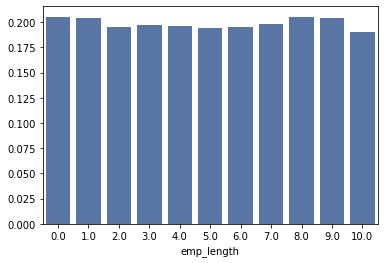

In [26]:
charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

La situación de los préstamos no parece variar mucho con la duración del empleo por término medio, por lo que se deja de lado

In [27]:
dataset.drop(['emp_length'], axis=1, inplace=True)

#### **Feature : Subgrade**

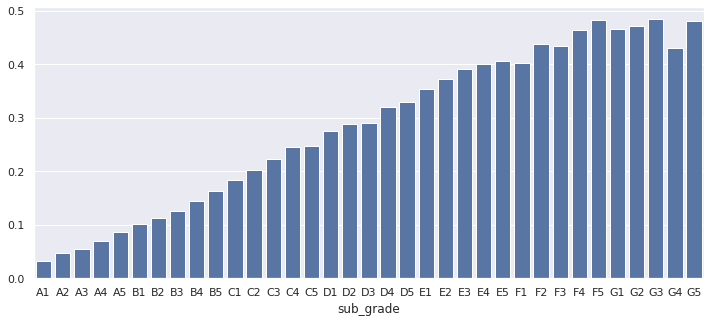

In [28]:
charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

Hay una clara tendencia de mayor probabilidad de impago a medida que empeora el subgrado.

In [29]:
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))

<a id='3.1.2'></a>
### 4.1.2. Analysing the continuous features

#### **Feature : Annual Income**

In [30]:
dataset[['annual_inc']].describe()

,annual_inc
count,7.057850e+05
mean,7.459489e+04
std,6.237069e+04
min,0.000000e+00
25%,4.500000e+04
50%,6.400000e+04
75%,9.000000e+04
max,8.900060e+06


* Los ingresos anuales oscilan entre 0 y 8,990.000, con una mediana de 64.000 dólares. Debido al amplio rango de ingresos, debemos tomar una transformación logarítmica de la variable de ingresos anuales.

In [31]:
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)

#### **FICO Scores**

In [32]:
dataset[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


* Dado que la correlación entre fico bajo y alto es 1 se prefiere mantener una sola característica que es la media de las puntuaciones FICO.

In [33]:
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']

dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [34]:
dataset['charged_off'].value_counts()

0    564833
1    140952
Name: charged_off, dtype: int64

<a id='3.2'></a>
## 4.2. Encoding Categorical Data

In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
# Máscara booleana categórica
categorical_feature_mask = dataset.dtypes==object
# filtrar columnas categóricas utilizando la máscara y convertirla en una lista
categorical_cols = dataset.columns[categorical_feature_mask].tolist()

In [37]:
categorical_cols

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [38]:
le = LabelEncoder()
# aplicar le en columnas de características categóricas
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))
dataset[categorical_cols].head(10)

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,2,10,5,1,2,45,1,0
1,0,2,1,0,1,4,1,0
2,3,15,5,1,1,24,1,0
4,2,12,5,1,2,3,0,0
5,2,12,5,1,2,31,0,0
6,1,9,1,1,4,23,0,0
7,1,8,4,2,2,45,1,0
8,2,13,5,1,1,47,0,0
9,1,8,5,0,2,20,0,0
10,1,9,5,2,2,22,0,0


In [39]:
dataset.head(5)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,dti,earliest_cr_line,open_acc,revol_util,initial_list_status,last_pymnt_amnt,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,15000.0,15000.0,60,12.39,336.64,2,10,5,1,2,45,12.03,1994,6.0,29.0,1,12017.81,0,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0,4.892100,752.0
1,10400.0,10400.0,36,6.99,321.08,0,2,1,0,1,4,14.92,1989,17.0,31.6,1,321.08,0,7.0,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,1,4.763435,712.0
2,21425.0,21425.0,60,15.59,516.36,3,15,5,1,1,24,18.49,2003,10.0,76.2,1,17813.19,0,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0,4.804827,687.0
4,7650.0,7650.0,36,13.66,260.20,2,12,5,1,2,3,34.81,2002,11.0,91.9,0,17.70,0,6.0,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,1,4.698979,687.0
5,9600.0,9600.0,36,13.66,326.53,2,12,5,1,2,31,25.81,1992,12.0,59.4,0,9338.58,0,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0,4.838855,682.0


In [40]:
dataset.shape

(705785, 29)

<a id='3.4'></a>
## 4.3. Sampling Data

In [41]:
loanstatus_0 = dataset[dataset["charged_off"]==0]
loanstatus_1 = dataset[dataset["charged_off"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)
dataset.head()

Current shape of dataset : (11000, 29)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,dti,earliest_cr_line,open_acc,revol_util,initial_list_status,last_pymnt_amnt,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,11500.0,11500.0,36,10.16,371.94,1,5,1,2,2,43,10.08,1998,4.0,70.6,0,19.25,0,1.0,41018.0,6353.0,70.6,176.0,19.0,3.0,2.0,0,4.544080,732.0
1,16000.0,16000.0,60,15.59,385.62,3,15,4,1,2,4,10.91,1999,14.0,46.0,1,385.62,0,8.0,27315.0,13556.0,36.9,111.0,3.0,3.0,5.0,1,4.812920,697.0
2,24000.0,24000.0,36,13.99,820.15,2,13,5,1,1,4,16.58,1997,14.0,92.0,1,9352.49,0,7.0,2971.0,1036.0,95.8,209.0,5.0,0.0,4.0,0,4.857339,682.0
3,8000.0,8000.0,36,15.59,279.64,2,14,4,1,7,9,30.33,2005,15.0,54.6,0,326.00,0,7.0,6736.0,1711.0,62.0,134.0,11.0,1.0,5.0,1,4.740371,667.0
4,13000.0,13000.0,60,18.84,336.09,4,21,1,0,2,2,14.77,2011,6.0,75.3,1,8805.15,0,4.0,17929.0,0.0,101.5,38.0,14.0,1.0,4.0,0,4.591076,662.0


In [42]:
# Rellenar los NA con la media de la columna.
dataset.fillna(dataset.mean(),inplace = True)

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [43]:
# dividir el conjunto de datos de validación para el final
Y= dataset["charged_off"]
X = dataset.loc[:, dataset.columns != 'charged_off']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [44]:
# dataset_temp2=dataset_temp.dropna(axis=0)
# Y_total= dataset_temp2["charged_off"]
# X_total = dataset_temp2.loc[:, dataset.columns != 'charged_off']
# X_dummy, X_validation, Y_dummy, Y_validation = train_test_split(X_total, Y_total, test_size=validation_size)

In [45]:
dataset['charged_off'].value_counts()

1    5500
0    5500
Name: charged_off, dtype: int64

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [46]:
# opciones de prueba para la clasificación
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

In [47]:
# comprobar los algoritmos al azar
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# Neural Network
models.append(('NN', MLPClassifier()))

#Ensable Models 

# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [48]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.913343 (0.011655)
LDA: 0.916941 (0.008772)
KNN: 0.856367 (0.013727)
CART: 0.827391 (0.011607)
NB: 0.921972 (0.007369)
NN: 0.895122 (0.012955)
AB: 0.942108 (0.009313)
GBM: 0.949904 (0.008000)
RF: 0.942464 (0.008179)
ET: 0.937704 (0.007395)


### **Algorithm comparison**

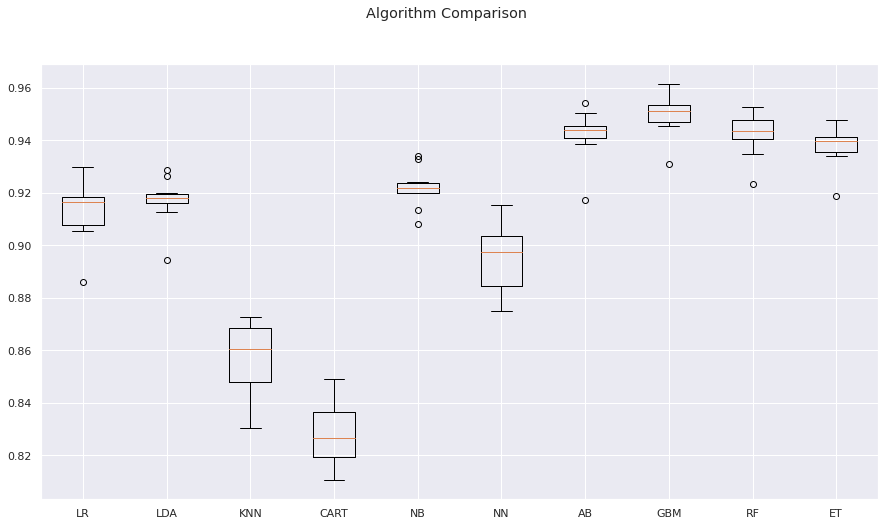

In [49]:
# comparar algoritmos
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Dado que el GBM es el mejor modelo, en este paso se realiza la búsqueda de cuadrícula en el GBM.

In [51]:
# Búsqueda en la cuadrícula: Ajuste de GradientBoosting
'''
n_estimators : int (por defecto=100)
    El número de etapas de refuerzo a realizar. 
    El refuerzo de gradiente es bastante robusto al sobreajuste, por lo que un número grande suele dar lugar a un mejor rendimiento.
max_depth : entero, opcional (por defecto=3)
    Profundidad máxima de los estimadores de regresión individuales. 
    La profundidad máxima limita el número de nodos en el árbol. 
    Ajuste este parámetro para obtener el mejor rendimiento; el mejor valor depende de la interacción de las variables de entrada.

''' 
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.952352 using {'max_depth': 3, 'n_estimators': 180}
#4 0.939652 (0.007216) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.952352 (0.008403) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.946079 (0.007502) with: {'max_depth': 5, 'n_estimators': 20}
#2 0.952252 (0.009650) with: {'max_depth': 5, 'n_estimators': 180}


<a id='6'></a>
# 7. Finalise the Model

Si se observan los detalles anteriores, la GBM podría ser digna de un estudio más profundo, pero por ahora la SVM se muestra muy prometedora como modelo estable y de baja complejidad para este problema.

Finalizar el modelo con los mejores parámetros encontrados durante el paso de ajuste.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [52]:
model = GradientBoostingClassifier(max_depth= 3, n_estimators= 180)
model.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=180)

In [53]:
# estimar la precisión en el conjunto de validación
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8768181818181818
[[ 887  193]
 [  78 1042]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1080
           1       0.84      0.93      0.88      1120

    accuracy                           0.88      2200
   macro avg       0.88      0.88      0.88      2200
weighted avg       0.88      0.88      0.88      2200



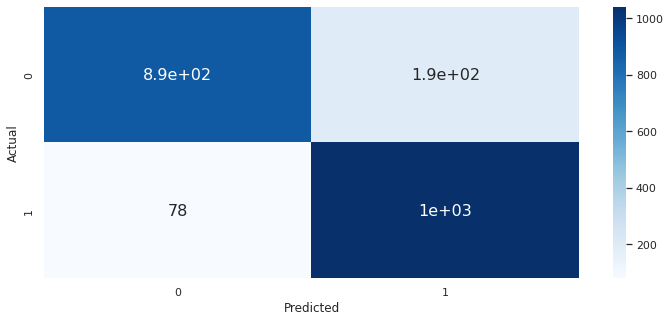

In [54]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Teniendo en cuenta los detalles anteriores, el GBM podría ser digno de un estudio más profundo. Veamos la importancia de las características del modelo GBM.

[1.02759134e-02 5.26260507e-03 3.21834094e-02 3.90175339e-03
 1.62014544e-02 4.07764419e-03 8.16086651e-02 6.02519264e-04
 9.84591339e-04 2.34920890e-03 1.09455825e-03 4.91777454e-03
 1.80078150e-03 5.44622862e-04 1.49526000e-03 4.97917904e-03
 7.88036941e-01 0.00000000e+00 1.68618461e-02 5.31996045e-03
 2.37649430e-03 1.78724289e-03 2.07239836e-03 3.34826252e-03
 1.75412303e-04 1.77889099e-03 2.45083644e-03 3.51177407e-03]


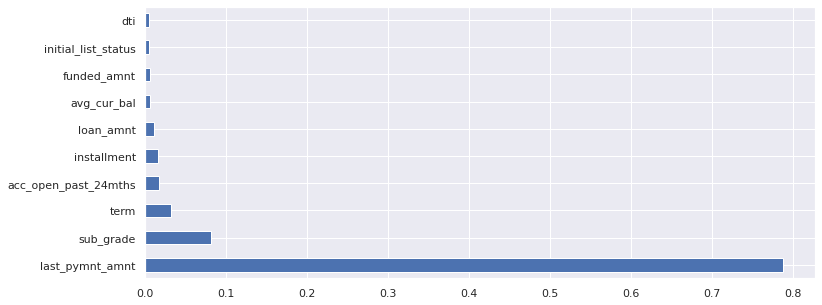

In [55]:
print(model.feature_importances_) # utilizar la clase incorporada feature_importances de los clasificadores basados en árboles
# trazar un gráfico de la importancia de las características para una mejor visualización
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

## **Conclusión:**

Hemos demostrado que la preparación de los datos es uno de los pasos más importantes. Lo abordamos realizando la eliminación de características mediante el uso de diferentes técnicas como el juicio subjetivo, la correlación, la visualización y la calidad de los datos de la característica. Ilustramos que puede haber diferentes maneras de manejar y analizar los datos categóricos y de convertir los datos categóricos en un formato utilizable por el modelo.

Por último, analizamos la importancia de las características y descubrimos que los resultados del estudio de casos son bastante intuitivos.
